In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV



from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb
import splitfolders

In [5]:
class config:
   

    
    data_path = 'Dataset/train'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [6]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.9, .1))

Copying files: 2900 files [00:27, 107.32 files/s]


## Loading and saving images as .npy files so we could deal with them

In [7]:
code = {'Closed':0 ,'no_yawn':1 ,'Open':2 ,'yawn':3}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [8]:
#NOTE: This cell would only run properly if data is hosted locally

#the directory that contain the train images set
trainpath='output/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

In [9]:
#NOTE: This cell would only run properly if data is hosted locally

#the directory that contain the train images set
testpath='output/val/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

## Loading the .npy files as numpy arrays

In [10]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('X_train.npy')
loaded_X_test = np.load('X_test.npy')
loaded_y_train = np.load('y_train.npy')
loaded_y_test = np.load('y_test.npy')

In [11]:
print(loaded_X_train.shape)
#the shape return dimensions of X_train, we have 5216 images of 64 x 64 pixels. 
#while the forth dimension stores the RGB information of each pixel

(2608, 64, 64, 3)


In [12]:
print(loaded_X_test.shape)

(292, 64, 64, 3)


In [13]:

print(loaded_y_train.shape)
print(loaded_y_test.shape)

(2608,)
(292,)


## Data Analysis

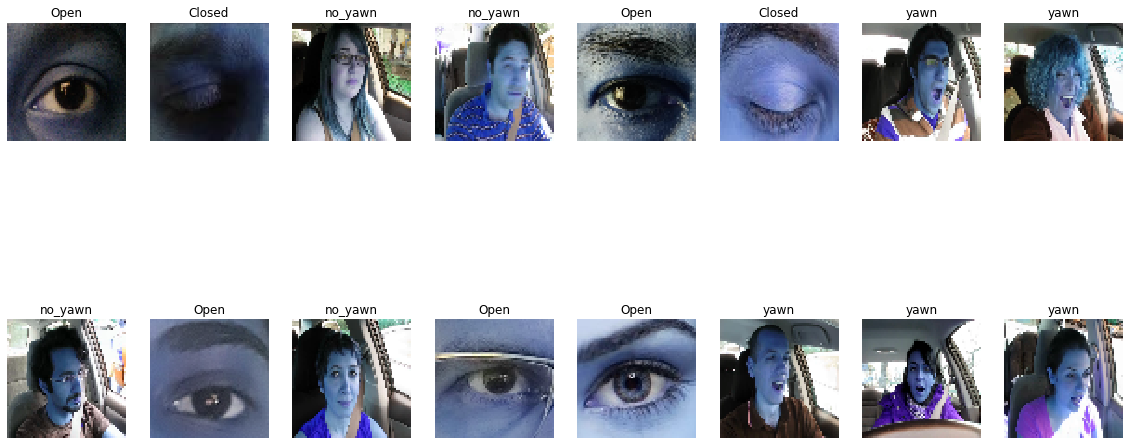

In [14]:

plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

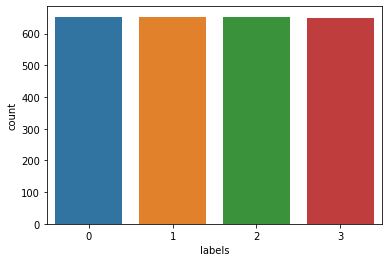

In [15]:
#count plot to show the number of pneumonia cases to normal cases in the train data set
df_train = pd.DataFrame()
df_train["labels"]= loaded_y_train
lab = df_train['labels']
dist = lab.value_counts()
sns.countplot(lab)
plt.show()

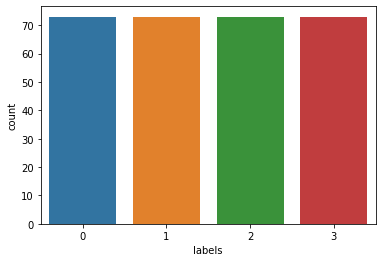

In [16]:
#count plot to show the number of pneumonia cases to normal cases in the test data set

df_test = pd.DataFrame()
df_test["labels"]= loaded_y_test
lab = df_test['labels']
dist = lab.value_counts()
#play with pallette colors
sns.countplot(lab)
plt.show()

In [17]:
#function to plot the pixel intensity of each image. 
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)


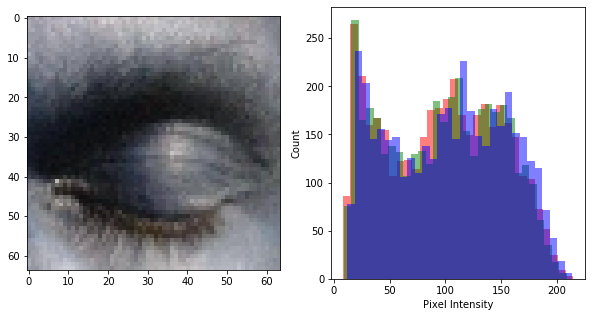

In [18]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

## Flatten and shuffle train and test sets 

In [19]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [20]:
print(X_train.shape)
print(X_test.shape)

(2608, 12288)
(292, 12288)


In [21]:
y_train = loaded_y_train
y_test = loaded_y_test

In [22]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

## Testing classification algorithms 

# Modified SVM

In [23]:

from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(X_train,y_train)
y_pred_svm =svm_clf.predict(X_test)

In [24]:

from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm

array([[67,  0,  6,  0],
       [ 0, 67,  0,  6],
       [ 6,  0, 67,  0],
       [ 0, 17,  0, 56]], dtype=int64)

In [25]:
from sklearn.metrics import accuracy_score
svm_result = accuracy_score(y_test,y_pred_svm)
print("Accuracy :",svm_result)

Accuracy : 0.8801369863013698


In [26]:
recall_svm = cm_svm[0][0]/(cm_svm[0][0] + cm_svm[0][1])
precision_svm = cm_svm[0][0]/(cm_svm[0][0]+cm_svm[1][1])
recall_svm,precision_svm

(1.0, 0.5)

# Naïve Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train, y_train)
predictions = GNB.predict(X_test)
val = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for GNB: ", val, "\n")
print("*Confusion Matrix for GNB: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for GNB: ")
print(classification_report(y_test, predictions))

*Accuracy score for GNB:  69.17808219178082 

*Confusion Matrix for GNB: 
[[56  1 16  0]
 [ 0 64  2  7]
 [ 9  1 58  5]
 [ 0 49  0 24]]
*Classification Report for GNB: 
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        73
           1       0.56      0.88      0.68        73
           2       0.76      0.79      0.78        73
           3       0.67      0.33      0.44        73

    accuracy                           0.69       292
   macro avg       0.71      0.69      0.68       292
weighted avg       0.71      0.69      0.68       292



In [28]:
cm = confusion_matrix(y_test,predictions)
cm
nb_result = accuracy_score(y_test,predictions)
print("Accuracy :",nb_result)
recall_nb = cm[0][0]/(cm[0][0] + cm[0][1])
precision_nb = cm[0][0]/(cm[0][0]+cm[1][1])
recall_nb,precision_nb

Accuracy : 0.6917808219178082


(0.9824561403508771, 0.4666666666666667)

# KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
predictions = KNN.predict(X_test)
val = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for KNN: ", val, "\n")
print("*Confusion Matrix for KNN: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for KNN: ")
print(classification_report(y_test, predictions))

*Accuracy score for KNN:  80.82191780821918 

*Confusion Matrix for KNN: 
[[70  0  3  0]
 [ 0 63  0 10]
 [32  0 41  0]
 [ 0 11  0 62]]
*Classification Report for KNN: 
              precision    recall  f1-score   support

           0       0.69      0.96      0.80        73
           1       0.85      0.86      0.86        73
           2       0.93      0.56      0.70        73
           3       0.86      0.85      0.86        73

    accuracy                           0.81       292
   macro avg       0.83      0.81      0.80       292
weighted avg       0.83      0.81      0.80       292



# Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
predictions = DT.predict(X_test)
val = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for DT: ", val, "\n")
print("*Confusion Matrix for DT: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for DT: ")
print(classification_report(y_test, predictions))

*Accuracy score for DT:  87.32876712328768 

*Confusion Matrix for DT: 
[[62  0 10  1]
 [ 0 62  1 10]
 [ 7  1 65  0]
 [ 0  7  0 66]]
*Classification Report for DT: 
              precision    recall  f1-score   support

           0       0.90      0.85      0.87        73
           1       0.89      0.85      0.87        73
           2       0.86      0.89      0.87        73
           3       0.86      0.90      0.88        73

    accuracy                           0.87       292
   macro avg       0.87      0.87      0.87       292
weighted avg       0.87      0.87      0.87       292



In [3]:
pip install split-folders


Note: you may need to restart the kernel to use updated packages.
